In [1]:
import torch
from torch import nn
from d2l import torch as d2l

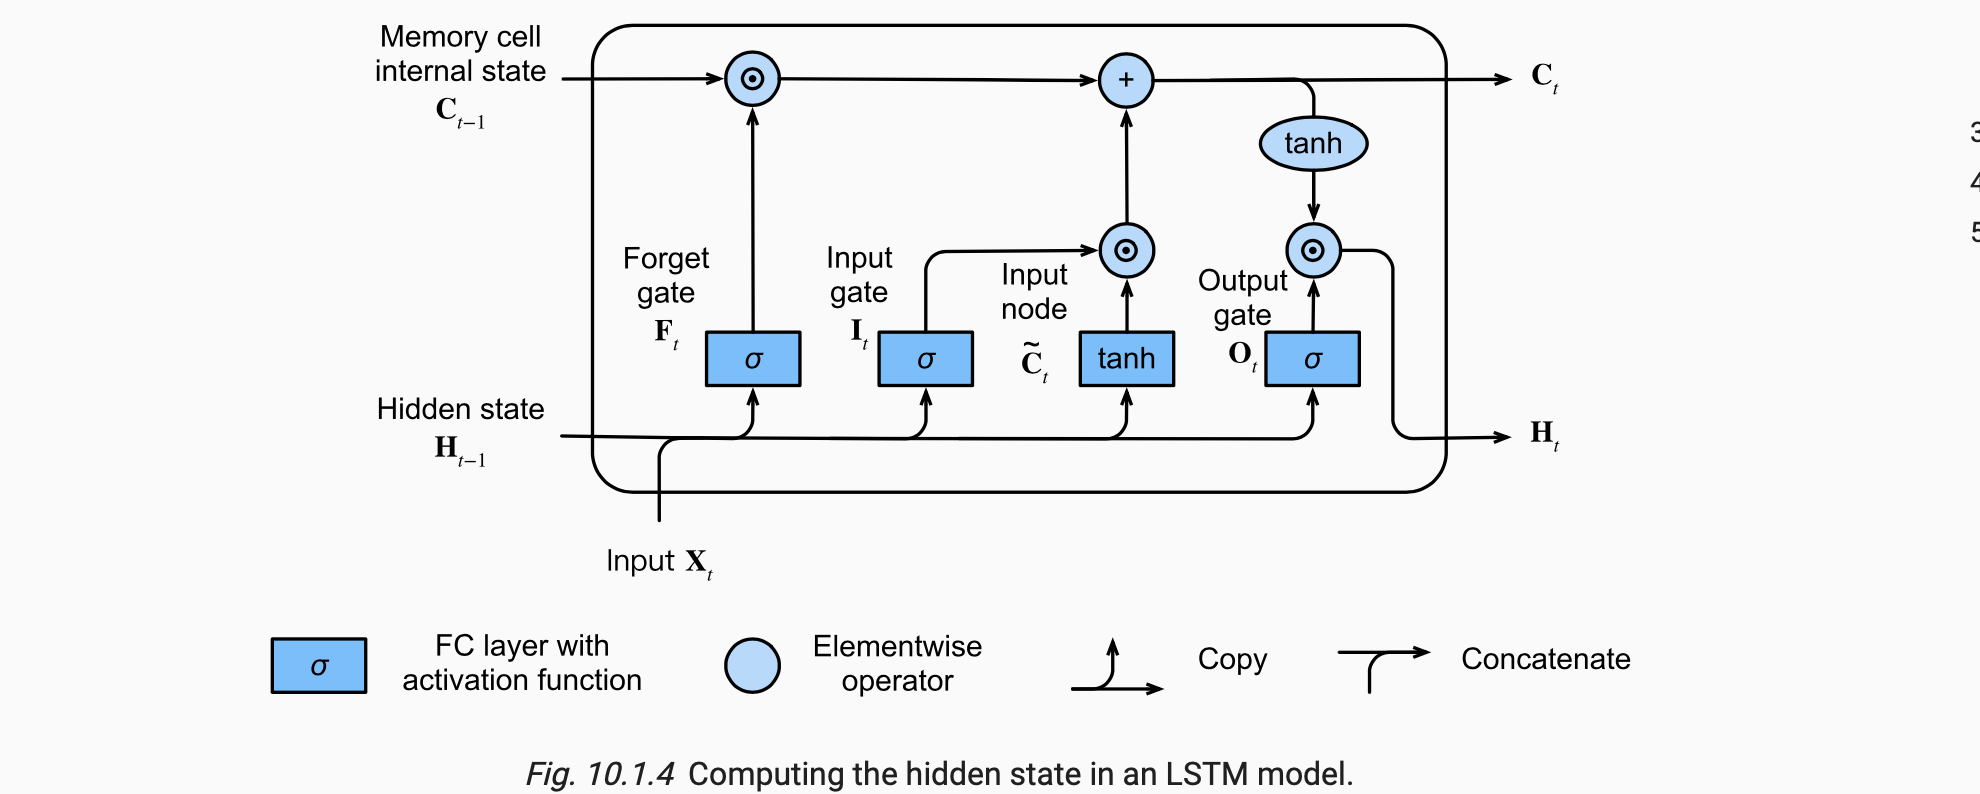
$$ \begin{split}\begin{aligned}
\mathbf{I}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xi} + \mathbf{H}_{t-1} \mathbf{W}_{hi} + \mathbf{b}_i),\\
\mathbf{F}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xf} + \mathbf{H}_{t-1} \mathbf{W}_{hf} + \mathbf{b}_f),\\
\mathbf{O}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xo} + \mathbf{H}_{t-1} \mathbf{W}_{ho} + \mathbf{b}_o),
\end{aligned}\end{split}$$
$$ \tilde{\mathbf{C}}_t = \text{tanh}(\mathbf{X}_t \mathbf{W}_{xc} + \mathbf{H}_{t-1} \mathbf{W}_{hc} + \mathbf{b}_c),$$
$$ \mathbf{C}_t = \mathbf{F}_t \odot \mathbf{C}_{t-1} + \mathbf{I}_t \odot \tilde{\mathbf{C}}_t. $$
$$\mathbf{H}_t = \mathbf{O}_t \odot \tanh(\mathbf{C}_t).$$

# Memory Cell Internal State

In [12]:
class LSTMScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))
        self.W_xi, self.W_hi, self.b_i = triple()  # Input gate
        self.W_xf, self.W_hf, self.b_f = triple()  # Forget gate
        self.W_xo, self.W_ho, self.b_o = triple()  # Output gate
        self.W_xc, self.W_hc, self.b_c = triple()  # Input node

In [17]:
@d2l.add_to_class(LSTMScratch)
def forward(self, inputs, H_C=None):
    if H_C is None:
         # Initial state with shape: (batch_size, num_hiddens)
        H=torch.zeros((inputs.shape[1],self.num_hiddens), device=inputs.device)
        C=torch.zeros((inputs.shape[1],self.num_hiddens), device=inputs.device)
    else:
        H,C=H_C
    outputs = []
    for X in inputs:
        I=torch.sigmoid(torch.mm(X,self.W_xi)+torch.mm(H, self.W_hi)+self.b_i)
        F=torch.sigmoid(torch.mm(X,self.W_xf)+torch.mm(H, self.W_hf)+self.b_f)
        O=torch.sigmoid(torch.mm(X,self.W_xo)+torch.mm(H, self.W_ho)+self.b_o)
        C_tilde=torch.tanh(torch.mm(X,self.W_xc)+torch.mm(H, self.W_hc)+self.b_c)
        C=F*C+I*C_tilde
        H=O*torch.tanh(C)
        outputs.append(H)
    return outputs,(H,C)

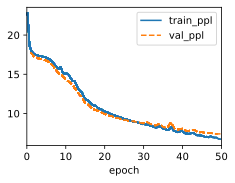

In [18]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
lstm = LSTMScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(lstm, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

# Concise Implementation

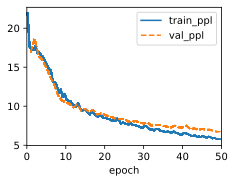

In [20]:
class LSTM(d2l.RNN):
    def __init__(self,num_inputs,num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn=nn.LSTM(num_inputs,num_hiddens)
    def forward(self, inputs, H_C=None):
        return self.rnn(inputs, H_C)
lstm=LSTM(len(data.vocab),32)
model=d2l.RNNLM(lstm,len(data.vocab),lr=4)
trainer.fit(model,data)

In [21]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has a mealle time the t'